In [1]:
import midynet
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import fractions
import json
import pandas as pd

from itertools import product
from matplotlib.lines import Line2D
from thresholds import *
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from midynet.statistics import Statistics
from midynet.utility import display

display.setup_dir("./")


paths_to_figures = ["."]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))
# path_to_data = pathlib.Path("../../../../data/midynet-data/figure4")
path_to_data = pathlib.Path("../../scripts/duality/data/figure4/")

In [2]:
ls "../../scripts/duality/data/figure4/"

geometric-cowanbw/ geometric-cowanfw/ geometric-glauber/ geometric-sis/


In [3]:
dynamics = ["glauber", "sis", "cowanfw", "cowanbw"]

recon = {}
pred = {}
thresholds = {}
x = {}

titles = {
    "glauber": r"Glauber", 
    "sis": r"SIS", 
    "cowanfw": r"Cowan",
    "cowanbw": r"Cowan"
}
xname = {
    "glauber": "coupling",
    "sis": "infection_prob",
    "cowanfw": "nu",
    "cowanbw": "nu",
}
xlabels = {
    "glauber": r"Coupling constant $J$", 
    "sis": r"Transmission rate $\lambda$", 
    "cowanfw": r"Potential gain $\nu$",
    "cowanbw": r"Potential gain $\nu$"
}

threshold_labels = {
    "glauber": r"$J_c$", 
    "sis": r"$\lambda_c$", 
    "cowanfw": r"$\nu_c^f$",
    "cowanbw": r"$\nu_c^b$"
}

for d in dynamics:
    df = next(iter(pd.read_pickle(path_to_data / f"geometric-{d}/reconinfo.pkl").values()))
    recon[d] = Statistics.from_dataframe(df, "recon")
    recon[d].rescale_(1/8)
    pred[d] = Statistics.from_dataframe(df, "pred")
    pred[d].rescale_(1/8)
    x[d] = df[f"data_model.{xname[d]}"]
    if d == "sis":
        x[d] /= 0.5
    if d.startswith("cowan"):
        suffix = "backward" if d.endswith("bw") else "forward"
        fname = f"threshold-cowan-{suffix}.json"
    else:
        fname = f"threshold-{d}.json"
    
        with open(fname, "r") as f:
            data = json.load(f)
        thresholds[d] = np.mean(data["thresholds"]) / 5
#     print(np.array(data["thresholds"])/5)

thresholds["cowanbw"] = 0.25
thresholds["cowanfw"] = 0.41



/var/folders/2c/1w3mn1rx56n3vszz9m6_9f3r0000gn/T/ipykernel_1329/345057169.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.15)


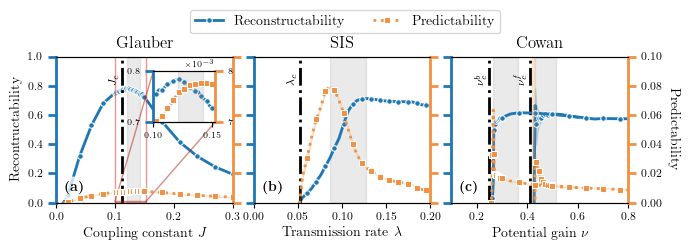

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(7, 7/3), sharex=False, sharey=False)
axx = np.array([_ax.twinx() for _ax in ax])

rcolor = display.med_colors["blue"]
rlinestyle = "solid"
rmarker = "o"

pcolor = display.med_colors["orange"]
plinestyle = "dotted"
pmarker = "s"

interpolation = None

markevery = [1, 2, 2]
markesize = 4
linewidth = 2

handles = []

for i, d in enumerate(dynamics):
    if d == "cowanbw":
        i -= 1
    recon[d].lineplot(
        x[d],
        color=rcolor,
        marker=rmarker,
        linestyle=rlinestyle,
        linewidth=linewidth,
        markersize=markesize,
        markevery=markevery[i],
        interpolate=interpolation,
        ax=ax[i]
    )
    augx, augy = recon[d].interpolate(x[d], kind="cubic")
    max_recon = augx[np.argmax(augy.loc)]
    
    ax[i].set_ylim([0, 1])
    if d.startswith("cowan"):
        xmin, xmax = 0.1, 0.8
    else:
        xmin, xmax = x[d].min(), x[d].max()
    ax[i].set_xlim([xmin, xmax])
    ax[i].axvline(thresholds[d], color="black", linestyle="-.", linewidth=2)
    if i == 0:
        ax[i].set_ylabel(r"Recontructability", fontsize=display.fontsizes["label"])
    else:
        ax[i].set_ylabel(None)
        ax[i].set_yticklabels([])
    ax[i].set_title(titles[d], fontsize=display.fontsizes["large_label"])
    ax[i].set_xlabel(xlabels[d], fontsize=display.fontsizes["label"])
    ax[i].tick_params(axis='both', labelsize=display.fontsizes["tick"])
    ax[i].text(
        thresholds[d] - 2 * (xmax - xmin) / 100, 
        0.8, 
        threshold_labels[d], 
        fontsize=8, 
        rotation=90, 
        horizontalalignment="right",
        va="bottom"
    )

    pred[d].lineplot(
        x[d],
        color=pcolor,
        marker=pmarker,
        linestyle=plinestyle,
        linewidth=linewidth,
        markersize=markesize,
        markevery=markevery[i],
        interpolate=interpolation,
        ax=axx[i],
    )
    augx, augy = pred[d].interpolate(x[d], kind="cubic")
    max_pred = augx[np.argmax(augy.loc)]
    axx[i].tick_params(axis='both', labelsize=display.fontsizes["tick"])
    axx[i].set_ylim([0, 0.1])
    if i == 2:
        axx[i].set_ylabel(r"Predictability", fontsize=display.fontsizes["label"], va="bottom", rotation=-90)
    else:
        axx[i].set_ylabel(None)
        axx[i].set_yticklabels([])
    max1, max2 = min(max_recon, max_pred), max(max_recon, max_pred)
    
    ax[i].axvspan(max1, max2, color=display.light_colors["grey"], alpha=0.2)
    
    ax[i].tick_params(axis='y', color=rcolor, length=6, width=2)
    axx[i].spines['left'].set_color(rcolor)
    axx[i].spines['left'].set_linewidth(2)
    axx[i].spines['right'].set_color(pcolor)
    axx[i].spines['right'].set_linewidth(2)
    axx[i].tick_params(axis='y', color=pcolor, length=6, width=2)
    if d != "cowanbw":
        display.Label.plot(ax[i], loc="bottom left")
    
    if d == "glauber":
        axins = ax[i].inset_axes([0.55, 0.55, 0.35, 0.35])
        xmin, xmax = 0.1, 0.16
        axxins = axins.twinx()
        idx = np.logical_and(x[d]>xmin, x[d]<xmax)
        recon[d].lineplot(
            x[d],
            indexes=idx,
            color=rcolor,
            marker=rmarker,
            linestyle=rlinestyle,
            linewidth=linewidth,
            markersize=markesize,
            markevery=2,
            interpolate=interpolation,
            ax=axins,
        )
        pred[d].lineplot(
            x[d],
            indexes=idx,
            color=pcolor,
            marker=pmarker,
            linestyle=plinestyle,
            linewidth=linewidth,
            markersize=markesize,
            markevery=2,
            interpolate=interpolation,
            ax=axxins,
        )
        axxins.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
        axxins.axvspan(max1, max2, color=display.light_colors["grey"], alpha=0.2)

        axins.set_ylim([0.7, 0.8])
        axxins.set_ylim([0.007, 0.008])
        axins.set_yticks([0.7, 0.8])
        axxins.set_yticks([0.007, 0.008])
        
        axins.set_xlabel(None)
        axins.set_ylabel(None)
        axxins.set_ylabel(None)
        axins.tick_params(axis="both", labelsize=display.fontsizes["tiny"])
        axxins.tick_params(axis="both", labelsize=display.fontsizes["tiny"])
        axxins.yaxis.offsetText.set_fontsize(display.fontsizes["tiny"])
        
        axins.tick_params(axis='y', color=rcolor, length=6, width=2)
        axxins.spines['left'].set_color(rcolor)
        axxins.spines['left'].set_linewidth(2)
        axxins.spines['right'].set_color(pcolor)
        axxins.spines['right'].set_linewidth(2)
        axxins.tick_params(axis='y', color=pcolor, length=6, width=2)
        
        ax[i].indicate_inset_zoom(axxins, edgecolor=display.dark_colors["red"])
        ax[i].axvline(axins.get_xlim()[0], linestyle="-", color=display.med_colors["red"], alpha=0.5, linewidth=1)
        ax[i].axvline(axins.get_xlim()[1], linestyle="-", color=display.med_colors["red"], alpha=0.5, linewidth=1)
        
        handles.append(display.get_label_line("Reconstructability", style=axins.get_lines()[0]))
        handles.append(display.get_label_line("Predictability", style=axxins.get_lines()[0]))
        
        
        
display.Label.clear()
        
lg = fig.legend(
    handles=handles, 
    loc="center",
    fontsize=10, 
    ncol=2, 
    bbox_to_anchor=(0.5, 1.0)
)
fig.tight_layout(w_pad=0.15)

for p, fmt in product(paths_to_figures, ["png", "pdf", "svg"]):
    fig.savefig(p / fmt / f"approx-duality-coupling.{fmt}", bbox_extra_artists=(lg,), bbox_inches='tight')
